In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from timeit import default_timer as timer 

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


# 1. Preparing data

In [3]:
# For Colab
# ucf_train_data_preprocessed_dir = "/content/drive/My Drive/Minki_ML_Data_free_to_delete/"

ucf_train_data_preprocessed_dir = "../resources/UCF-101/data_preprocessed/train"
ucf_test_data_preprocessed_dir = "../resources/UCF-101/data_preprocessed/test"
batch_size = 512

In [4]:
class_list = os.listdir(ucf_train_data_preprocessed_dir)
class_list_test = os.listdir(ucf_test_data_preprocessed_dir)

In [5]:
from torch.utils.data import Dataset

class UCFDataset(Dataset):
    def __init__(self, root_dir, frames_per_clip, transform=None):
        self.root_dir = root_dir
        self.frames_per_clip = frames_per_clip
        self.transform = transform
        self.classes = sorted(file for file in os.listdir(root_dir) if file != '.DS_Store')

    def __len__(self):
        return sum([len(files) for _, _, files in os.walk(self.root_dir)])

    def __getitem__(self, idx):
        # Calculate accumulated number of videos for each class
        accum_video_counts = [0]
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            accum_video_counts.append(accum_video_counts[-1] + len(os.listdir(class_dir)))

        # Determine the class index
        class_idx = next(i for i, count in enumerate(accum_video_counts[1:]) if idx < count)
        class_name = self.classes[class_idx]
        class_dir = os.path.join(self.root_dir, class_name)
        video_files = sorted(os.listdir(class_dir))

        # Adjust the index based on the accumulated counts
        adjusted_idx = idx - accum_video_counts[class_idx]
        video_name = video_files[adjusted_idx % len(video_files)]
        video_path = os.path.join(class_dir, video_name)
        frame_position = (adjusted_idx % len(video_files)) % self.frames_per_clip
        frame = torch.load(video_path)[frame_position]
        frame = frame.permute([2, 0, 1])
        # frame = frame.to(device)

        label = class_name
        target = torch.tensor(class_list.index(label))
        # target = target.to(device)

        if self.transform:
            frame = self.transform(frame)

        return frame, target


In [6]:
frames_per_clip = 5

train_dataset = UCFDataset(ucf_train_data_preprocessed_dir, frames_per_clip)
test_dataset = UCFDataset(ucf_test_data_preprocessed_dir, frames_per_clip)

In [7]:
from torchvision.transforms.functional import resize

def custom_collate_fn(batch):
    images, labels = zip(*batch)

    # Resize all images in the batch to a common size
    images = [resize(img, (240, 320)) for img in images]

    return torch.stack(images), labels

In [8]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, pin_memory=False)

In [9]:
# Show a batch
skip_execution = True

if not skip_execution:
    for x, y in train_loader:
        print("Shape of Batch: ", x.shape)

        fig, axes = plt.subplots(7,5,figsize=(10, 10))

        # Loop through the subplots and display the images
        for ax, image, label in zip(axes.flat, x, y):
            image = image.to(dtype=torch.int)
            image = torch.permute(image, [1,2,0])
            ax.imshow(image)  # You can set the colormap here
            ax.axis('off')  # Turn off axis labels and ticks
            ax.set_title(label, fontsize=10, pad=5)  # Set title as the label


        # Adjust spacing between subplots for better layout
        plt.tight_layout()

        # Show the grid of images
        plt.show()
        break


# 2. Building the model

In [10]:
import torch.nn as nn

def conv(input_channel, output_channel):
  conv = nn.Conv2d(input_channel, output_channel, groups=1, bias=True, kernel_size=3, padding=0, stride=2)
  m = nn.Sequential(conv, nn.ReLU())
  return m

In [11]:
full_net = nn.Sequential(
    nn.Linear(128, 72),
    nn.ReLU(),
)

In [12]:
cnn = nn.Sequential(
    conv(3, 32),
    conv(32, 64),
    conv(64, 128),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    full_net
)

Fully connected layer (Filtered image to class)

In [13]:
def accuracy_top3(y, targets):
    accuracies = []
    _, top_3_indices = torch.topk(y, 3)
    for target,result in zip(targets,top_3_indices):
        # print("target: ", target)
        # print("top_3_indices: ", result)
        # print("--------")
        if target in result:
            accuracies.append(1)
        else:
            accuracies.append(0)

    return sum(accuracies) / len(accuracies)


# 3. Training

## With the training data

In [14]:
import torch.optim as optim

accuracies = []
count = 0
num_epochs = 0
skip_execution = True

if not skip_execution:
    for epoch in range(num_epochs): 
        for x, y in train_loader:
            count += 1     
            target = [class_list.index(y[i]) for i in range(len(y))]
            target_in_array = torch.tensor([[1 if i == value else 0 for i in range(len(class_list))] for value in target], dtype=torch.float32)
            
            loss_function = nn.MSELoss()
            optimizer = optim.SGD(cnn.parameters(), lr=1e-3)

            res = cnn(x)
            accuracy = accuracy_top3(res, target)
            accuracies.append(accuracy)

            loss = loss_function(res, target_in_array)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print("Total epoches", count)
    print("Total acc", len(accuracies))
    plt.plot(accuracies)
    plt.xlabel('Batch')
    plt.ylabel('Top-3 Accuracy')
    plt.title('Training Top-3 Accuracy')
    plt.ylim(0, 1)
    plt.show()

## Check the accuracy with the testing data

In [15]:

accuracies = []

skip_execution = True

if not skip_execution:
    for x, y in test_loader:
        target = [class_list_test.index(y[i]) for i in range(len(y))]
        
        res = cnn(x)
        
        accuracy = accuracy_top3(res, target)
        accuracies.append(accuracy)

    print("Average accuracy: ",sum(accuracies) / len(accuracies))

    print(len(accuracies))
    plt.plot(accuracies)
    plt.xlabel('Batch')
    plt.ylabel('Top-3 Accuracy')
    plt.title('Training Top-3 Accuracy')
    plt.show()

# 4. Troubleshooting

I was training a model from scratch. But the frames from the videos that I’m using to train the model are too little to train image classification. I’d better use a pre-trained model.

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetForClassification(nn.Module):
    def __init__(self, pretrained, num_ftrs, class_num):
        super(ResNetForClassification, self).__init__()
        self.pretrained = pretrained
        self.pretrained.fc = nn.Linear(num_ftrs, class_num)
        torch.nn.init.xavier_uniform_(self.pretrained.fc.weight)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.pretrained(x)
        output = self.relu(output)
        return output

In [17]:
import torchvision.models as models

# Load the pre-trained ResNet-34 model
resnet34_pretrained = models.resnet34(pretrained=True)
num_ftrs = resnet34_pretrained.fc.in_features

resnet34 = ResNetForClassification(resnet34_pretrained, num_ftrs, 72).to(device)


/Users/jungminki/Documents/Code/ML/notebooks/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jungminki/Documents/Code/ML/notebooks/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
for int, (X, y) in enumerate(train_loader):
    print(int, "th Batch")


0 th Batch
1 th Batch
2 th Batch
3 th Batch
4 th Batch
5 th Batch
6 th Batch
7 th Batch


Total batches:  19
0 th Batch
0.033203125
1 th Batch
0.041015625
2 th Batch
0.03515625
3 th Batch
0.037109375
4 th Batch
0.044921875
5 th Batch
0.03515625
6 th Batch
0.037109375
7 th Batch
0.048828125
Total time:  68.43477908299997
Total acc 8


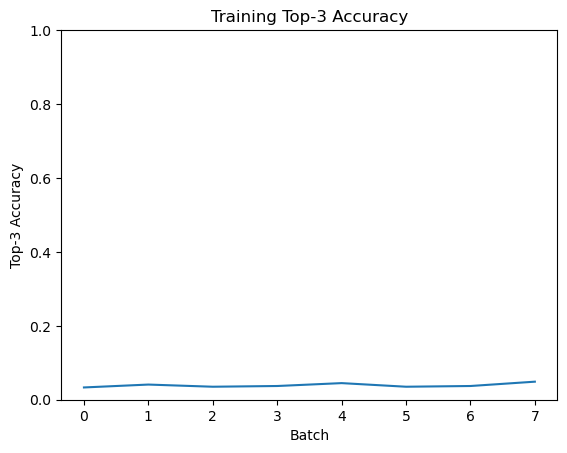

In [24]:
import torch.optim as optim
# from torch.profiler import profile, ProfilerActivity

# with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
accuracies = []
num_epochs = 1
lr = 1e-5
weight_decay = 5e-4

loss_function = nn.MSELoss()
# params_1x = [param for name, param in resnet34.named_parameters() if 'fc' not in str(name)]

# Freeze all layers
for param in resnet34.parameters():
    param.requires_grad = False

# Unfreeze the last layer (assuming it's named "layerN")
for name, param in resnet34.named_parameters():
    if "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(resnet34.parameters(), lr=lr, weight_decay=weight_decay)

start_t = timer()
print("Total batches: ", len(train_loader))

for epoch in range(num_epochs): 
    for int, (X, y) in enumerate(train_loader):
        print(int, "th Batch")
        X = X.to(device)
        optimizer.zero_grad()

        y_diagonal_array = torch.zeros([batch_size, 72], device=device)
        for i in range(batch_size):
            y_diagonal_array[i][y[i].item()] = 1

        y_diagonal_array = y_diagonal_array.to(device)

        resnet34.train()
        res = resnet34(X)
        accuracy = accuracy_top3(res, list(y))
        accuracies.append(accuracy)
        print(accuracy)
        loss = loss_function(res, y_diagonal_array)

        loss.backward()
        optimizer.step()

end_t = timer()
print("Total time: ", end_t - start_t)

# print(prof.key_averages().table(sort_by="self_cpu_time_total"))
print("Total acc", len(accuracies))
plt.plot(accuracies)
plt.xlabel('Batch')
plt.ylabel('Top-3 Accuracy')
plt.title('Training Top-3 Accuracy')
plt.ylim(0, 1)
plt.show()

There is something wrong with the model. I'll try the following adjustments.
1. Try different learning rates

In [19]:
# # Finding learning rate

# import torch.optim as optim

# initial_lr = 1e-7
# final_lr = 1
# step_size = len(train_loader)
# def lr_lambda(epoch):
#     mul = (final_lr / initial_lr) ** (epoch / step_size)
#     return mul
# optimizer = optim.SGD(cnn.parameters(), lr=initial_lr)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# lr_find_loss = []
# lr_find_lr = []

# # Loop through each batch to get the loss and lr
# for i, (inputs, labels) in enumerate(train_loader):
#     target_in_array = torch.tensor([[1 if i == value else 0 for i in range(len(class_list))] for value in labels], dtype=torch.float32)

#     optimizer.zero_grad()
#     outputs = cnn(inputs)
#     lossFunction = nn.MSELoss()
#     loss = lossFunction(outputs, target_in_array)

#     # Record this iteration's loss and learning rate
#     lr_find_loss.append(loss.item())
#     lr_find_lr.append(optimizer.param_groups[0]['lr'])

#     # Backward pass
#     loss.backward()
#     optimizer.step()

#     # Step with the learning rate scheduler
#     scheduler.step()

# # Plot the learning rate range test results
# plt.semilogx(lr_find_lr, lr_find_loss)
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.show()
